# Data Understanding

## Data Size

In [3]:
import pandas as pd
from datetime import datetime
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from statistics import mean 
import matplotlib.ticker as mtick
import matplotlib as mpl


conn = sqlite3.connect('./bank_database.db')

COLOR = "white"
mpl.rcParams['text.color'] = "black"

mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

loans = pd.read_sql('''SELECT * FROM loan_dev''', conn)

print("All")
print(loans.describe())

loans_p = pd.read_sql('''SELECT * FROM loan_dev WHERE status = 1''', conn)
loans_up = pd.read_sql('''SELECT * FROM loan_dev WHERE status = -1''', conn)

print("\nPayed")
print(loans_p.describe())
print("\nUnpayed")
print(loans_up.describe())

All
           loan_id    account_id         amount    duration     payments  \
count   328.000000    328.000000     328.000000  328.000000   328.000000   
mean   6205.658537   5982.085366  145308.621951   35.853659  4150.932927   
std     667.985675   3213.262492  105247.318098   16.734752  2193.620989   
min    4959.000000      2.000000    4980.000000   12.000000   319.000000   
25%    5604.250000   3079.000000   68328.000000   24.000000  2368.750000   
50%    6227.500000   6032.000000  114804.000000   36.000000  3878.500000   
75%    6737.250000   8564.500000  198600.000000   48.000000  5907.750000   
max    7308.000000  11362.000000  538500.000000   60.000000  9689.000000   

           status  
count  328.000000  
mean     0.719512  
std      0.695541  
min     -1.000000  
25%      1.000000  
50%      1.000000  
75%      1.000000  
max      1.000000  

Payed
          loan_id    account_id         amount    duration     payments  \
count   282.00000    282.000000     282.000000  2

## Age at loan destribution

To make the destribution of ages at the time of loan first we needed to get the necessary data from the sqlite database into python.

For that we joined the loan, disposition and client Tables selecting the loan date and birth_date and made sure we were only selecting clients who were account OWNERS since only they can take loans.

In [4]:
loan_dev_df = pd.read_sql('''SELECT loan_dev.date, birth_number, disp.type FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER"
''', conn)

loan_dev_df = loan_dev_df.loc[:, ~loan_dev_df.columns.duplicated()]
print(loan_dev_df.head())
print()
print(loan_dev_df.describe())


         date birth_number   type
0  1994-01-05   1945-02-04  OWNER
1  1996-04-29   1939-04-23  OWNER
2  1996-05-02   1944-06-13  OWNER
3  1996-11-06   1945-07-03  OWNER
4  1994-05-31   1939-11-30  OWNER

              date birth_number   type
count          328          328    328
unique         283          318      1
top     1995-12-12   1945-02-04  OWNER
freq             3            2    328


number of loans: 328
youngest: 13
oldest: 60
average: 35.75609756097561
number of people younger then 18: 22. Making up 6.71% of loans
age that asks for the most loans: 46 with 13 loans. Making up 3.96% of loans


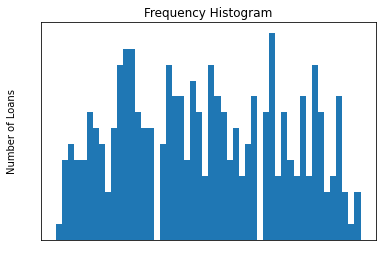

       age_at_loan
count   328.000000
mean     35.756098
std      12.533318
min      13.000000
25%      25.000000
50%      35.000000
75%      46.000000
max      60.000000


In [5]:
def get_age_at_loan(loan_dev_df):
    age_at_loan = []
    for i in range(loan_dev_df['birth_number'].size):
        try:
            loan_dev_df['date'][i]
        except:
            age_at_loan.append(np.NaN)
            continue

        age_at_loan.append(int((datetime.strptime(loan_dev_df['date'][i], '%Y-%m-%d').date(
        ) - datetime.strptime(loan_dev_df['birth_number'][i], '%Y-%m-%d').date()).days / 365.25))
    return age_at_loan
    
age_at_loan = get_age_at_loan(loan_dev_df)

print("number of loans: " + str(len(age_at_loan)))
print("youngest: " + str(min(age_at_loan)))
print("oldest: " + str(max(age_at_loan)))
print("average: " + str(mean(age_at_loan)))
counter = 0
for i in age_at_loan:
    if i < 18:
        counter += 1
print("number of people younger then 18: " + str(counter) + ". Making up " + str(round(counter/len(age_at_loan)*100,2)) + "% of loans")
counter = 0
num  = age_at_loan[0]
for i in age_at_loan:
        curr_frequency = age_at_loan.count(i)
        if(curr_frequency> counter):
            counter = curr_frequency
            num = i
print("age that asks for the most loans: " + str(num) + " with " + str(counter) + " loans. Making up " + str(round(counter/len(age_at_loan)*100,2)) + "% of loans")

plt.hist(age_at_loan, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Number of Loans')
plt.show()
df = pd.DataFrame(age_at_loan, columns = ["age_at_loan"])
print(df.describe())

Making this destribution let us come to a couple conclusions: 
- The youngest age at which someone has made a loan is 13 which should be impossible since the minimum age to make a loan is 18, after looking further we came to the conclusion that there are in fact 22 entries (almost 7%) of loans which were made by people younger than 18 which might need to be dealt with seperatly
- The oldest age was made by someone who was 60 years old
- The average age for making a loan is between 35 and 36
- Most loans were made by people who were 46 years old making up almost 4% of loans

## Loan ammount

   amount
0   96396
1  165960
2  127080
3  105804
4  274740


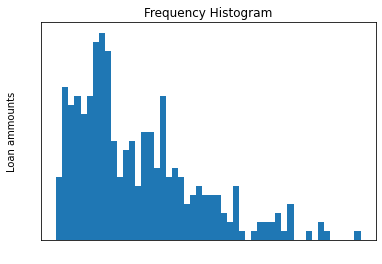

              amount
count     328.000000
mean   145308.621951
std    105247.318098
min      4980.000000
25%     68328.000000
50%    114804.000000
75%    198600.000000
max    538500.000000


In [6]:
loan_dev_df = pd.read_sql('''SELECT amount FROM loan_dev ''', conn)

loan_dev_df = loan_dev_df.loc[:, ~loan_dev_df.columns.duplicated()]

print(loan_dev_df.head())

plt.hist(loan_dev_df["amount"], bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Loan ammounts')
plt.show()

print(loan_dev_df.describe())

## Duration

   duration
0        12
1        36
2        60
3        36
4        60


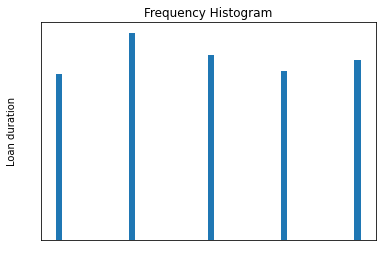

         duration
count  328.000000
mean    35.853659
std     16.734752
min     12.000000
25%     24.000000
50%     36.000000
75%     48.000000
max     60.000000


In [7]:
loan_dev_df = pd.read_sql('''SELECT duration FROM loan_dev ''', conn)

loan_dev_df = loan_dev_df.loc[:, ~loan_dev_df.columns.duplicated()]

print(loan_dev_df.head())

plt.hist(loan_dev_df["duration"], bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Loan duration')
plt.show()

print(loan_dev_df.describe())

## Date

        date
0 1993-07-05
1 1993-07-11
2 1993-07-28
3 1993-08-03
4 1993-09-06
                                date
count                            328
mean   1995-06-21 08:02:55.609756160
min              1993-07-05 00:00:00
25%              1994-08-09 06:00:00
50%              1995-05-31 00:00:00
75%              1996-05-25 06:00:00
max              1996-12-27 00:00:00


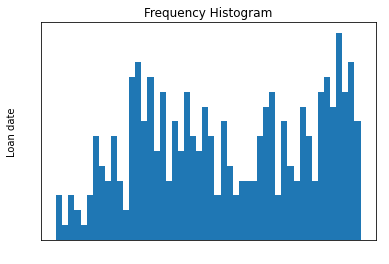

In [8]:
loan_dev_df = pd.read_sql('''SELECT date FROM loan_dev ''', conn)

loan_dev_df = loan_dev_df.loc[:, ~loan_dev_df.columns.duplicated()]
loan_dev_df['date']= pd.to_datetime(loan_dev_df['date'])

print(loan_dev_df.head())
print(loan_dev_df.describe(datetime_is_numeric=True))

plt.hist(loan_dev_df["date"], bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Loan date')
plt.show()



## Payments

   payments
0      8033
1      4610
2      2118
3      2939
4      4579


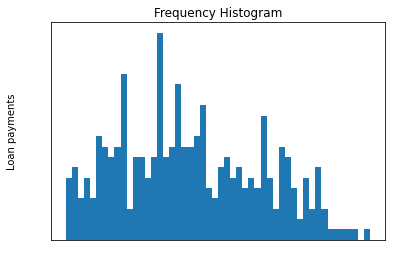

          payments
count   328.000000
mean   4150.932927
std    2193.620989
min     319.000000
25%    2368.750000
50%    3878.500000
75%    5907.750000
max    9689.000000


In [9]:
loan_dev_df = pd.read_sql('''SELECT payments FROM loan_dev ''', conn)

loan_dev_df = loan_dev_df.loc[:, ~loan_dev_df.columns.duplicated()]

print(loan_dev_df.head())

plt.hist(loan_dev_df["payments"], bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Loan payments')
plt.show()

print(loan_dev_df.describe())

## Status vs Loan amount

Paid loans amount

   amount
0  165960
1  127080
2  105804
3  274740
4   87840
              amount
count     282.000000
mean   139865.914894
std    103692.396883
min      4980.000000
25%     63324.000000
50%    106722.000000
75%    193662.000000
max    538500.000000

Unpaid loans amount

   amount
0   96396
1  174744
2  464520
3   75624
4   49320
              amount
count      46.000000
mean   178674.782609
std    109673.150761
min     29448.000000
25%     89511.000000
50%    171864.000000
75%    246600.000000
max    482940.000000


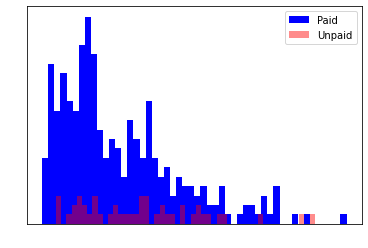

In [10]:
loan_payed = pd.read_sql('''SELECT amount FROM loan_dev WHERE status = "1" ''', conn)
loan_unpayed = pd.read_sql('''SELECT amount FROM loan_dev WHERE status = "-1" ''', conn)

loan_payed = loan_payed.loc[:, ~loan_payed.columns.duplicated()]
loan_unpayed = loan_unpayed.loc[:, ~loan_unpayed.columns.duplicated()]

print("Paid loans amount\n")
print(loan_payed.head())
print(loan_payed.describe())
print()
print("Unpaid loans amount\n")
print(loan_unpayed.head())
print(loan_unpayed.describe())

plt.hist(loan_payed["amount"], bins=50, color='blue')
plt.hist(loan_unpayed["amount"], bins=50, color='red', alpha=0.45)
plt.legend(['Paid', 
            'Unpaid'])
plt.show()




## Status vs Age at loan

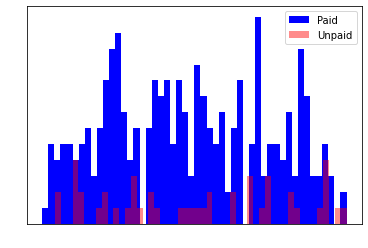

   age_at_loan_payed
0                 48
1                 51
2                 51
3                 54
4                 54

       age_at_loan_payed
count         282.000000
mean           35.620567
std            12.303459
min            13.000000
25%            25.000000
50%            35.000000
75%            46.000000
max            60.000000
   age_at_loan_unpayed
0                   57
1                   47
2                   28
3                   42
4                   39

       age_at_loan_unpayed
count            46.000000
mean             36.586957
std              13.978676
min              15.000000
25%              24.500000
50%              36.500000
75%              48.000000
max              60.000000


In [17]:
loan_dev_df_payed = pd.read_sql('''SELECT loan_dev.date, birth_number, disp.type, status FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER"and status = 1
''', conn)

loan_dev_df_unpayed = pd.read_sql('''SELECT loan_dev.date, birth_number, disp.type, status FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = -1
''', conn)

loan_dev_df_payed = loan_dev_df_payed.loc[:, ~loan_dev_df_payed.columns.duplicated()]
loan_dev_df_unpayed = loan_dev_df_unpayed.loc[:, ~loan_dev_df_unpayed.columns.duplicated()]

age_at_loan_payed = get_age_at_loan(loan_dev_df_payed)
age_at_loan_unpayed = get_age_at_loan(loan_dev_df_unpayed)

age_payed = pd.DataFrame(age_at_loan_payed, columns = ["age_at_loan_payed"])
age_unpayed = pd.DataFrame(age_at_loan_unpayed, columns = ["age_at_loan_unpayed"])


plt.hist(age_at_loan_payed, bins=50, color='blue')
plt.hist(age_at_loan_unpayed, bins=50, color='red', alpha=0.45)
plt.legend(['Paid', 
            'Unpaid'])
plt.show()


print(age_payed.head())
print()
print(age_payed.describe())

print(age_unpayed.head())
print()
print(age_unpayed.describe())

## Status vs duration

Paid loans duration

   duration
0        36
1        60
2        36
3        60
4        24
         duration
count  282.000000
mean    35.829787
std     16.878868
min     12.000000
25%     24.000000
50%     36.000000
75%     48.000000
max     60.000000

Unpaid loans duration

   duration
0        12
1        24
2        60
3        24
4        12
       duration
count      46.0
mean       36.0
std        16.0
min        12.0
25%        24.0
50%        36.0
75%        48.0
max        60.0


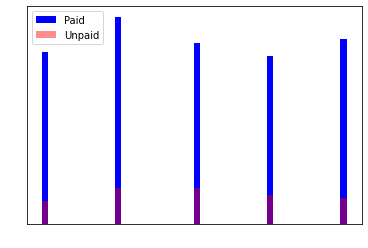

In [12]:
loan_payed = pd.read_sql('''SELECT duration FROM loan_dev WHERE status = "1" ''', conn)
loan_unpayed = pd.read_sql('''SELECT duration FROM loan_dev WHERE status = "-1" ''', conn)

loan_payed = loan_payed.loc[:, ~loan_payed.columns.duplicated()]
loan_unpayed = loan_unpayed.loc[:, ~loan_unpayed.columns.duplicated()]

print("Paid loans duration\n")
print(loan_payed.head())
print(loan_payed.describe())
print()
print("Unpaid loans duration\n")
print(loan_unpayed.head())
print(loan_unpayed.describe())

plt.hist(loan_payed["duration"], bins=50, color='blue')
plt.hist(loan_unpayed["duration"], bins=50, color='red', alpha=0.45)
plt.legend(['Paid', 
            'Unpaid'])
plt.show()

## Status vs payments

Paid loans payments

   payments
0      4610
1      2118
2      2939
3      4579
4      3660
          payments
count   282.000000
mean   4001.932624
std    2153.345360
min     319.000000
25%    2142.500000
50%    3802.500000
75%    5628.750000
max    9689.000000

Unpaid loans payments

   payments
0      8033
1      7281
2      7742
3      3151
4      4110
          payments
count    46.000000
mean   5064.369565
std    2240.564288
min    1671.000000
25%    3050.500000
50%    4701.000000
75%    7281.000000
max    8308.000000


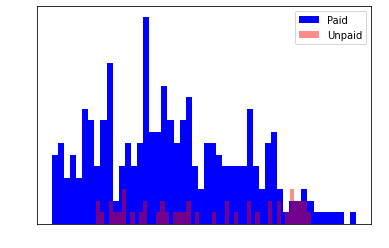

In [13]:
loan_payed = pd.read_sql('''SELECT payments FROM loan_dev WHERE status = "1" ''', conn)
loan_unpayed = pd.read_sql('''SELECT payments FROM loan_dev WHERE status = "-1" ''', conn)

loan_payed = loan_payed.loc[:, ~loan_payed.columns.duplicated()]
loan_unpayed = loan_unpayed.loc[:, ~loan_unpayed.columns.duplicated()]

print("Paid loans payments\n")
print(loan_payed.head())
print(loan_payed.describe())
print()
print("Unpaid loans payments\n")
print(loan_unpayed.head())
print(loan_unpayed.describe())

plt.hist(loan_payed["payments"], bins=50, color='blue')
plt.hist(loan_unpayed["payments"], bins=50, color='red', alpha=0.45)
plt.legend(['Paid', 
            'Unpaid'])
plt.show()

## District

          name
0        Pisek
1  Hl.m. Praha
2  Hl.m. Praha
3        Kolin
4        Kolin

               name
count          5369
unique           77
top     Hl.m. Praha
freq            663


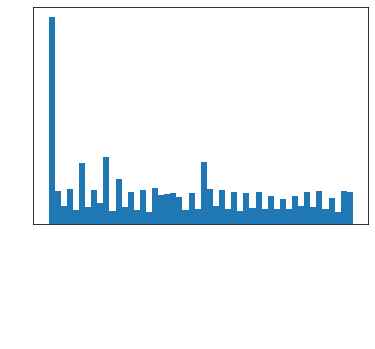

In [14]:
district_client = pd.read_sql('''SELECT name FROM client JOIN district ON district.code = client.district_id''', conn)

district_client = district_client.loc[:, ~district_client.columns.duplicated()]

print(district_client.head())
print()
print(district_client.describe())

fig, ax = plt.subplots()
plt.rcParams.update({'font.size': 10})
ax.hist(district_client["name"], bins=50)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

## Region

            region
0    south Bohemia
1           Prague
2           Prague
3  central Bohemia
4  central Bohemia

               region
count            5369
unique              8
top     south Moravia
freq              937


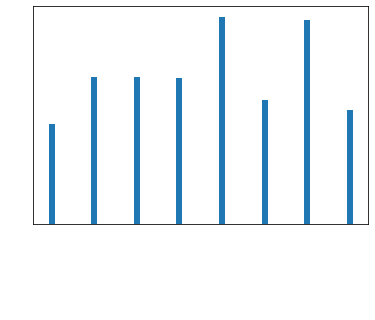

In [15]:
district_client = pd.read_sql('''SELECT region FROM client JOIN district ON district.code = client.district_id''', conn)

district_client = district_client.loc[:, ~district_client.columns.duplicated()]

print(district_client.head())
print()
print(district_client.describe())

fig, ax = plt.subplots()
ax.hist(district_client["region"], bins=50)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

## Average zone salary

   average salary 
0             8968
1            12541
2            12541
3             9307
4             9307

       average salary 
count      5369.000000
mean       9510.758614
std        1330.686689
min        8110.000000
25%        8547.000000
50%        8980.000000
75%        9897.000000
max       12541.000000


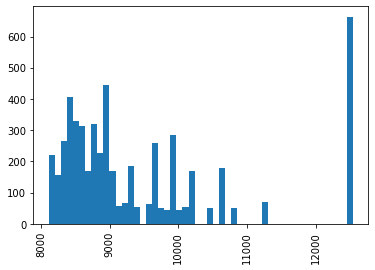

In [143]:
district_client = pd.read_sql('''SELECT "average salary " FROM client JOIN district ON district.code = client.district_id''', conn)

district_client = district_client.loc[:, ~district_client.columns.duplicated()]

print(district_client.head())
print()
print(district_client.describe())


fig, ax = plt.subplots()
ax.hist(district_client["average salary "], bins=50)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

## no. of inhabitants

   no. of inhabitants
0               70699
1             1204953
2             1204953
3               95616
4               95616

       no. of inhabitants
count        5.369000e+03
mean         2.692806e+05
std          3.590500e+05
min          4.282100e+04
25%          8.888400e+04
50%          1.219470e+05
75%          2.261220e+05
max          1.204953e+06


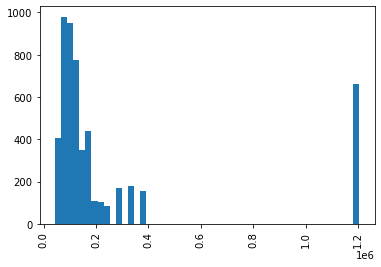

In [145]:
district_client = pd.read_sql('''SELECT "no. of inhabitants" FROM client JOIN district ON district.code = client.district_id''', conn)

district_client = district_client.loc[:, ~district_client.columns.duplicated()]

print(district_client.head())
print()
print(district_client.describe())


fig, ax = plt.subplots()
ax.hist(district_client["no. of inhabitants"], bins=50)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

## ratio of urban inhabitants 

   ratio of urban inhabitants 
0                         65.3
1                        100.0
2                        100.0
3                         51.4
4                         51.4

       ratio of urban inhabitants 
count                  5369.000000
mean                     69.240045
std                      19.896870
min                      33.900000
25%                      52.700000
50%                      63.100000
75%                      85.600000
max                     100.000000


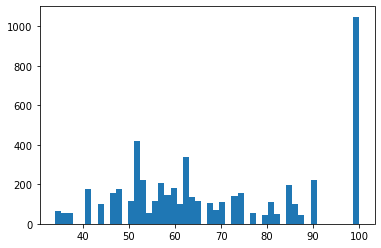

In [160]:
district_client = pd.read_sql('''SELECT "ratio of urban inhabitants " FROM client JOIN district ON district.code = client.district_id''', conn)

district_client = district_client.loc[:, ~district_client.columns.duplicated()]

print(district_client.head())
print()
print(district_client.describe())


fig, ax = plt.subplots()
ax.hist(district_client["ratio of urban inhabitants "], bins=50)

plt.show()

## unemploymant rate

   unemploymant rate '95   unemploymant rate '96 
0                    2.83                    3.35
1                    0.29                    0.43
2                    0.29                    0.43
3                    3.85                    4.43
4                    3.85                    4.43

       unemploymant rate '95   unemploymant rate '96 
count             5369.000000             5369.000000
mean                 2.912486                3.490942
std                  1.889014                2.134924
min                  0.290000                0.430000
25%                  1.600000                1.960000
50%                  2.770000                3.470000
75%                  4.010000                4.790000
max                  7.340000                9.400000


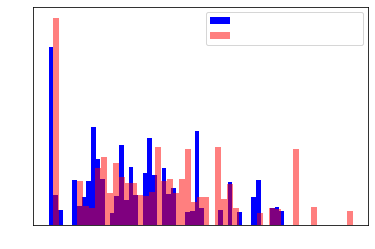

In [22]:
district_client = pd.read_sql('''SELECT  "unemploymant rate '95 ", "unemploymant rate '96 " FROM client LEFT JOIN district ON district.code = client.district_id''', conn)


district_client.loc[district_client["unemploymant rate '95 "] == '?',
                "unemploymant rate '95 "] = district_client["unemploymant rate '96 "]

district_client["unemploymant rate '95 "] = district_client["unemploymant rate '95 "].astype('float')

print(district_client.head())
print()
print(district_client.describe())


fig, ax = plt.subplots()
ax.hist(district_client["unemploymant rate '95 "], bins=50, color="blue")
ax.hist(district_client["unemploymant rate '96 "], bins=50, alpha = 0.5, color="red")
plt.legend(["unemploymant rate '95 ", 
            "unemploymant rate '96 "])
plt.show()



## no enterpreneurs

   no. of enterpreneurs per 1000 inhabitants 
0                                         131
1                                         167
2                                         167
3                                         118
4                                         118

       no. of enterpreneurs per 1000 inhabitants 
count                                 5369.000000
mean                                   121.191097
std                                     23.106521
min                                     81.000000
25%                                    105.000000
50%                                    116.000000
75%                                    131.000000
max                                    167.000000


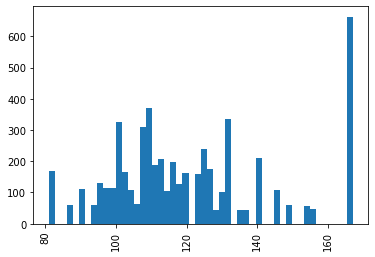

In [235]:
district_client = pd.read_sql('''SELECT "no. of enterpreneurs per 1000 inhabitants " FROM client JOIN district ON district.code = client.district_id''', conn)

district_client = district_client.loc[:, ~district_client.columns.duplicated()]

print(district_client.head())
print()
print(district_client.describe())


fig, ax = plt.subplots()
ax.hist(district_client["no. of enterpreneurs per 1000 inhabitants "], bins=50)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

## crime rate

   no. of commited crimes '95   no. of commited crimes '96 
0                       1740.0                         1910
1                      85677.0                        99107
2                      85677.0                        99107
3                       2616.0                         3040
4                       2616.0                         3040

       no. of commited crimes '95   no. of commited crimes '96 
count                  5369.000000                  5369.000000
mean                  14665.696405                 16352.240082
std                   26977.698874                 31330.146616
min                     818.000000                   888.000000
25%                    2159.000000                  2252.000000
50%                    3729.000000                  3839.000000
75%                    6604.000000                  6295.000000
max                   85677.000000                 99107.000000


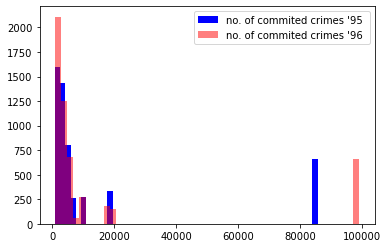

In [224]:
district_client = pd.read_sql('''SELECT  "no. of commited crimes '95 ", "no. of commited crimes '96 " FROM client LEFT JOIN district ON district.code = client.district_id''', conn)


district_client.loc[district_client["no. of commited crimes '95 "] == '?',
                "no. of commited crimes '95 "] = district_client["no. of commited crimes '96 "]

district_client["no. of commited crimes '95 "] = district_client["no. of commited crimes '95 "].astype('float')

print(district_client.head())
print()
print(district_client.describe())


fig, ax = plt.subplots()
ax.hist(district_client["no. of commited crimes '95 "], bins=50, color="blue")
ax.hist(district_client["no. of commited crimes '96 "], bins=50, alpha = 0.5, color="red")
plt.legend(["no. of commited crimes '95 ", 
            "no. of commited crimes '96 "])
plt.show()


## Status vs District

               name
count            73
unique           73
top     Hl.m. Praha
freq              1
                name
0        Hl.m. Praha
1  Jindrichuv Hradec
2            Teplice
3   Zdar nad Sazavou
4            Breclav

               name
count           282
unique           71
top     Hl.m. Praha
freq             35
           name
0         Tabor
1   Hl.m. Praha
2     Prostejov
3  Brno - mesto
4       Jesenik

               name
count            46
unique           30
top     Hl.m. Praha
freq              6


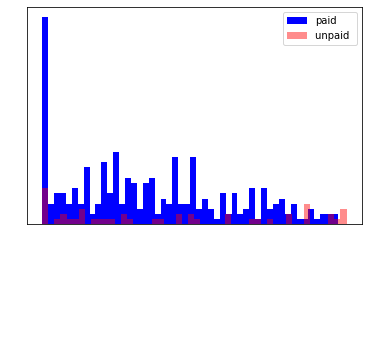

In [25]:
district_client_all = pd.read_sql('''SELECT DISTINCT district.name FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER"
''', conn)

district_client_p = pd.read_sql('''SELECT district.name FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = 1
''', conn)

district_client_up = pd.read_sql('''SELECT district.name FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = -1
''', conn)


print(district_client_all.describe())

print(district_client_p.head())
print()
print(district_client_p.describe())

print(district_client_up.head())
print()
print(district_client_up.describe())

fig, ax = plt.subplots()
ax.hist(district_client_p["name"], bins=50, color = "blue")
ax.hist(district_client_up["name"], bins=50, color = "red", alpha = 0.45)
plt.legend(["paid", 
            "unpaid "])
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()



In [58]:
for district in district_client_all["name"]:
    payed = district_client_p["name"].tolist().count(district)
    unpayed = district_client_up["name"].tolist().count(district)
    percentage = round(payed/(payed+unpayed)*100,2)
    if (percentage <= 50):
        print(district + " - " + str(payed) +"/"+str(payed+unpayed) + " ("+ str(percentage) +"%)\n")

Tabor - 2/4 (50.0%)

Breclav - 1/2 (50.0%)

Jesenik - 1/3 (33.33%)

Strakonice - 2/4 (50.0%)

Sokolov - 0/1 (0.0%)

Bruntal - 1/2 (50.0%)

Opava - 0/2 (0.0%)

Kromeriz - 2/4 (50.0%)

Karlovy Vary - 2/4 (50.0%)

Havlickuv Brod - 1/2 (50.0%)



## Status vs Region

In [1]:
district_client_p = pd.read_sql('''SELECT district.region FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = 1
''', conn)

district_client_up = pd.read_sql('''SELECT district.region FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = -1
''', conn)


print(district_client_p.head())
print()
print(district_client_p.describe())

print(district_client_up.head())
print()
print(district_client_up.describe())

fig, ax = plt.subplots()
ax.hist(district_client_p["region"], bins=50, color = "blue")
ax.hist(district_client_up["region"], bins=50, color = "red", alpha = 0.45)
plt.legend(["paid", 
            "unpaid "])
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
plt.show()

NameError: name 'pd' is not defined

## Status vs Average Salary

   average salary 
0            12541
1             8427
2             9317
3             8512
4             8772

       average salary 
count       282.000000
mean       9530.166667
std        1314.350269
min        8110.000000
25%        8547.000000
50%        8994.000000
75%        9914.250000
max       12541.000000
   average salary 
0             9104
1            12541
2             8441
3             9897
4             8173

       average salary 
count        46.000000
mean       9480.130435
std        1364.826039
min        8110.000000
25%        8469.750000
50%        8991.000000
75%        9896.000000
max       12541.000000


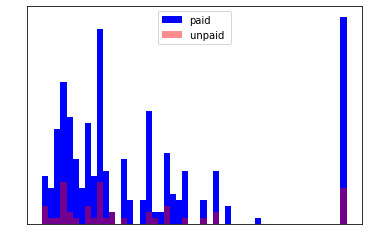

In [4]:
district_client_p = pd.read_sql('''SELECT district."average salary " FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = 1
''', conn)

district_client_up = pd.read_sql('''SELECT district."average salary " FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = -1
''', conn)


print(district_client_p.head())
print()
print(district_client_p.describe())

print(district_client_up.head())
print()
print(district_client_up.describe())

fig, ax = plt.subplots()
ax.hist(district_client_p["average salary "], bins=50, color = "blue")
ax.hist(district_client_up["average salary "], bins=50, color = "red", alpha = 0.45)
plt.legend(["paid", 
            "unpaid "])
plt.show()

## Status vs no of inhabitants

   no. of inhabitants
0             1204953
1               93931
2              128118
3              125832
4              124605

       no. of inhabitants
count        2.820000e+02
mean         2.706327e+05
std          3.596212e+05
min          4.282100e+04
25%          8.888400e+04
50%          1.255340e+05
75%          2.261220e+05
max          1.204953e+06
   no. of inhabitants
0              103347
1             1204953
2              110643
3              387570
4               42821

       no. of inhabitants
count        4.600000e+01
mean         2.788209e+05
std          3.725584e+05
min          4.282100e+04
25%          9.501300e+04
50%          1.170475e+05
75%          2.281665e+05
max          1.204953e+06


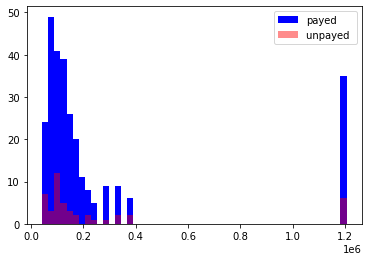

In [230]:
district_client_p = pd.read_sql('''SELECT "no. of inhabitants" FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = 1
''', conn)

district_client_up = pd.read_sql('''SELECT "no. of inhabitants" FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = -1
''', conn)


print(district_client_p.head())
print()
print(district_client_p.describe())

print(district_client_up.head())
print()
print(district_client_up.describe())

fig, ax = plt.subplots()
ax.hist(district_client_p["no. of inhabitants"], bins=50, color = "blue")
ax.hist(district_client_up["no. of inhabitants"], bins=50, color = "red", alpha = 0.45)
plt.legend(["paid", 
            "unpaid "])
plt.show()

## Status vs urban ratio

   ratio of urban inhabitants 
0                        100.0
1                         56.9
2                         85.3
3                         48.3
4                         46.0

       ratio of urban inhabitants 
count                   282.000000
mean                     67.825887
std                      20.342879
min                      33.900000
25%                      52.700000
50%                      61.900000
75%                      85.500000
max                     100.000000
   ratio of urban inhabitants 
0                         67.0
1                        100.0
2                         51.9
3                        100.0
4                         48.4

       ratio of urban inhabitants 
count                    46.000000
mean                     68.523913
std                      19.985597
min                      36.500000
25%                      54.025000
50%                      62.000000
75%                      87.875000
max                     100.000

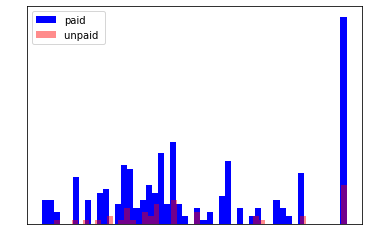

In [5]:
district_client_p = pd.read_sql('''SELECT district."ratio of urban inhabitants " FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = 1
''', conn)

district_client_up = pd.read_sql('''SELECT district."ratio of urban inhabitants " FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = -1
''', conn)


print(district_client_p.head())
print()
print(district_client_p.describe())

print(district_client_up.head())
print()
print(district_client_up.describe())

fig, ax = plt.subplots()
ax.hist(district_client_p["ratio of urban inhabitants "], bins=50, color = "blue")
ax.hist(district_client_up["ratio of urban inhabitants "], bins=50, color = "red", alpha = 0.45)
plt.legend(["paid", 
            "unpaid "])
plt.show()

## Status vs umployment

   unemploymant rate '95   unemploymant rate '96 
0                    0.29                    0.43
1                    1.12                    1.54
2                    6.49                    7.07
3                    3.51                    4.12
4                    4.69                    4.98

       unemploymant rate '95   unemploymant rate '96 
count              282.000000              282.000000
mean                 2.890177                3.498617
std                  1.944651                2.218888
min                  0.290000                0.430000
25%                  1.510000                1.860000
50%                  2.645000                3.470000
75%                  3.850000                4.772500
max                  7.340000                9.400000
   unemploymant rate '95   unemploymant rate '96 
0                    1.51                    2.07
1                    0.29                    0.43
2                    3.45                    4.48
3            

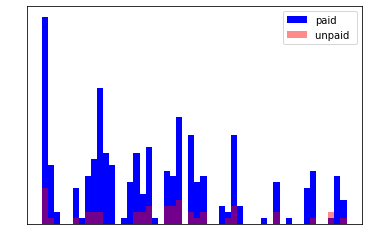

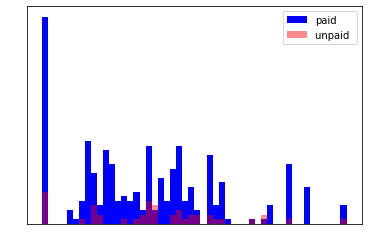

In [6]:
district_client_p = pd.read_sql('''SELECT  "unemploymant rate '95 ", "unemploymant rate '96 " FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = 1
''', conn)

district_client_up = pd.read_sql('''SELECT  "unemploymant rate '95 ", "unemploymant rate '96 " FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = -1
''', conn)

district_client_p.loc[district_client_p["unemploymant rate '95 "] == '?',
                "unemploymant rate '95 "] = district_client_p["unemploymant rate '96 "]

district_client_p["unemploymant rate '95 "] = district_client_p["unemploymant rate '95 "].astype('float')

district_client_up.loc[district_client_up["unemploymant rate '95 "] == '?',
                "unemploymant rate '95 "] = district_client_up["unemploymant rate '96 "]

district_client_up["unemploymant rate '95 "] = district_client_up["unemploymant rate '95 "].astype('float')

print(district_client_p.head())
print()
print(district_client_p.describe())

print(district_client_up.head())
print()
print(district_client_up.describe())

fig, ax = plt.subplots()
ax.hist(district_client_p["unemploymant rate '95 "], bins=50, color = "blue")
ax.hist(district_client_up["unemploymant rate '95 "], bins=50, color = "red", alpha = 0.45)
plt.legend(["paid", 
            "unpaid "])
plt.show()
fig1, ax1 = plt.subplots()
ax1.hist(district_client_p["unemploymant rate '96 "], bins=50, color = "blue")
ax1.hist(district_client_up["unemploymant rate '96 "], bins=50, color = "red", alpha = 0.45)
plt.legend(["paid", 
            "unpaid "])
plt.show()


## Status vs crime

   no. of commited crimes '95   no. of commited crimes '96 
0                      85677.0                        99107
1                       1874.0                         1913
2                       6949.0                         6872
3                       2247.0                         2103
4                       2854.0                         3158

       no. of commited crimes '95   no. of commited crimes '96 
count                   282.000000                   282.000000
mean                  14621.308511                 16312.946809
std                   27087.962322                 31461.404507
min                     818.000000                   888.000000
25%                    2159.000000                  2265.250000
50%                    3659.000000                  3839.000000
75%                    6862.750000                  6727.750000
max                   85677.000000                 99107.000000
   no. of commited crimes '95   no. of commited crimes '96 
0  

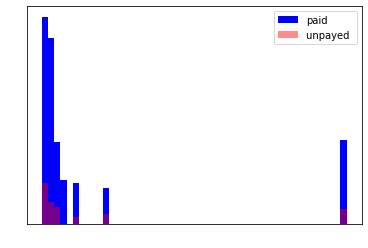

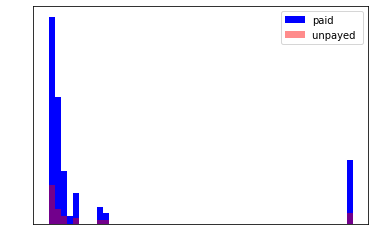

In [7]:
district_client_p = pd.read_sql('''SELECT  "no. of commited crimes '95 ", "no. of commited crimes '96 " FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = 1
''', conn)

district_client_up = pd.read_sql('''SELECT  "no. of commited crimes '95 ", "no. of commited crimes '96 " FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = -1
''', conn)

district_client_p.loc[district_client_p["no. of commited crimes '95 "] == '?',
                "no. of commited crimes '95 "] = district_client_p["no. of commited crimes '96 "]

district_client_p["no. of commited crimes '95 "] = district_client_p["no. of commited crimes '95 "].astype('float')

district_client_up.loc[district_client_up["no. of commited crimes '95 "] == '?',
                "no. of commited crimes '95 "] = district_client_up["no. of commited crimes '96 "]

district_client_up["no. of commited crimes '95 "] = district_client_up["no. of commited crimes '95 "].astype('float')

print(district_client_p.head())
print()
print(district_client_p.describe())

print(district_client_up.head())
print()
print(district_client_up.describe())

fig, ax = plt.subplots()
ax.hist(district_client_p["no. of commited crimes '95 "], bins=50, color = "blue")
ax.hist(district_client_up["no. of commited crimes '95 "], bins=50, color = "red", alpha = 0.45)
plt.legend(["paid", 
            "unpayed "])
plt.show()
fig1, ax1 = plt.subplots()
ax1.hist(district_client_p["no. of commited crimes '96 "], bins=50, color = "blue")
ax1.hist(district_client_up["no. of commited crimes '96 "], bins=50, color = "red", alpha = 0.45)
plt.legend(["paid", 
            "unpayed "])
plt.show()


## Status vs no entrepeneurs

   no. of enterpreneurs per 1000 inhabitants 
0                                         167
1                                         107
2                                          97
3                                         102
4                                         126

       no. of enterpreneurs per 1000 inhabitants 
count                                  282.000000
mean                                   121.783688
std                                     23.267270
min                                     81.000000
25%                                    107.000000
50%                                    115.000000
75%                                    135.000000
max                                    167.000000
   no. of enterpreneurs per 1000 inhabitants 
0                                         123
1                                         167
2                                         115
3                                         140
4                                         1

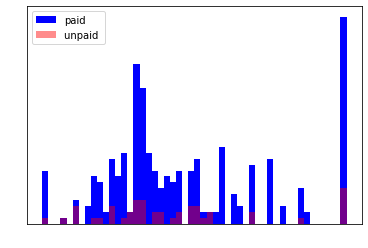

In [8]:
district_client_p = pd.read_sql('''SELECT district."no. of enterpreneurs per 1000 inhabitants " FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = 1
''', conn)

district_client_up = pd.read_sql('''SELECT district."no. of enterpreneurs per 1000 inhabitants " FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    WHERE disp.type = "OWNER" and status = -1
''', conn)


print(district_client_p.head())
print()
print(district_client_p.describe())

print(district_client_up.head())
print()
print(district_client_up.describe())

fig, ax = plt.subplots()
ax.hist(district_client_p["no. of enterpreneurs per 1000 inhabitants "], bins=50, color = "blue")
ax.hist(district_client_up["no. of enterpreneurs per 1000 inhabitants "], bins=50, color = "red", alpha = 0.45)
plt.legend(["paid", 
            "unpaid "])
plt.show()

<AxesSubplot:>

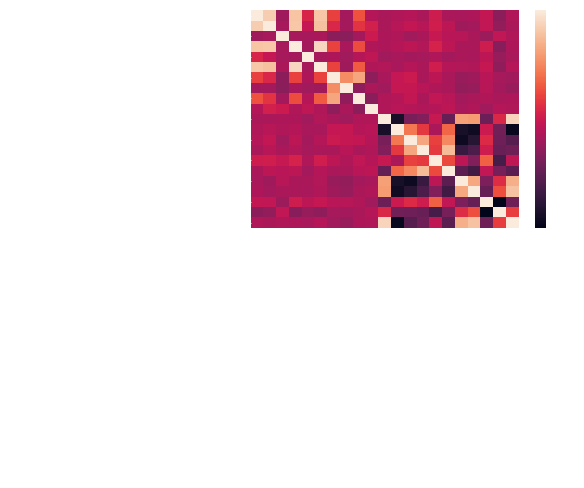

In [29]:
import seaborn as sns
features = pd.read_sql('''SELECT * FROM account
    JOIN loan_dev ON loan_dev.account_id = account.account_id
    LEFT JOIN disp ON disp.account_id = account.account_id
    LEFT JOIN client ON client.client_id = disp.client_id
    LEFT JOIN district ON district.code = client.district_id
    LEFT JOIN card_dev ON card_dev.disp_id = disp.disp_id
''', conn)

features = features.drop(['account_id', 'district_id', 'loan_id', 'district_id', 'disp_id','card_id','client_id','code'], axis=1)

corr = features.corr(method ='spearman')

sns.heatmap(corr)


<AxesSubplot:>

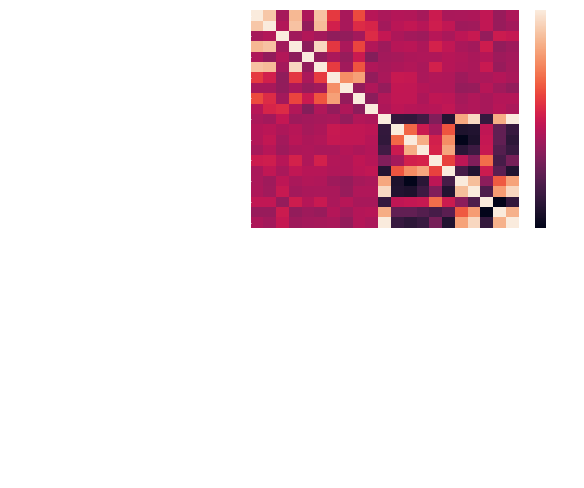

In [30]:
corr = features.corr(method ='pearson')

sns.heatmap(corr)

In [19]:
from tabulate import tabulate

labels = ["AUC","Accuracy","Balanced Accuracy","F1 Score","Precision","Average Fit Times"]

random_forest = [0.6884910192147035,0.8780885780885781,0.5655555555555555,0.9337964195297414,0.8758547008547009,0.316283130645752]
gaussian = [0.6574979114452798, 0.8444289044289043, 0.5532038429406849, 0.913767926988266, 0.8740092165898619, 0.0036533355712890627]
k_neighbours = [0.5397970620996937, 0.8475058275058274, 0.4928884711779449, 0.9173639523039363, 0.858007368975111, 0.002705812454223633]
logistic_regression = [0.7460059871901977, 0.8718881118881118, 0.6087050960735171, 0.9290277236523139, 0.8874196260288276, 0.4227468967437744]
svc = [0.693454469507101, 0.8749184149184149, 0.6269507101086049, 0.930404878161608, 0.8927329119555456, 116.71701259613037]
stack_classifier = [0.7389891395154553, 0.875011655011655, 0.5731578947368421, 0.9318165613352779, 0.877948717948718, 2761.4730689525604]

table = [labels,
        ["Random Forest"]+random_forest,
        ["GaussianNB"] + gaussian,
        ["KNeighborsClassifier"] + k_neighbours,
        ["LogisticRegression"]+logistic_regression,
        ["SVC"]+svc,
        ["StackingClassifier"] +stack_classifier ]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))


╒══════════════════════╤══════════╤════════════╤═════════════════════╤════════════╤═════════════╤═════════════════════╕
│                      │      AUC │   Accuracy │   Balanced Accuracy │   F1 Score │   Precision │   Average Fit Times │
╞══════════════════════╪══════════╪════════════╪═════════════════════╪════════════╪═════════════╪═════════════════════╡
│ Random Forest        │ 0.688491 │   0.878089 │            0.565556 │   0.933796 │    0.875855 │          0.316283   │
├──────────────────────┼──────────┼────────────┼─────────────────────┼────────────┼─────────────┼─────────────────────┤
│ GaussianNB           │ 0.657498 │   0.844429 │            0.553204 │   0.913768 │    0.874009 │          0.00365334 │
├──────────────────────┼──────────┼────────────┼─────────────────────┼────────────┼─────────────┼─────────────────────┤
│ KNeighborsClassifier │ 0.539797 │   0.847506 │            0.492888 │   0.917364 │    0.858007 │          0.00270581 │
├──────────────────────┼──────────┼─────